# Merton Problem:  At any time $t$ and wealth $x$, find the optimal fraction $u^*$ of the portfolio that should be in stock (vs. cash) for the investor so as to maximize the utility of the portfolio at the final time $t=T$.

Implement the function that analytically solves Merton's problem for power law utility and then complete the dynamic programming solution that calculates both the optimal stock fraction and the value function at each $(t,x)$ for general utility functions. Note that all of the code fot the setup (problem specification and discretization) and for plotting optimal solutions is done for you. Places where you need to add code are indicated with $\star$.

Starter code courtesy Dan Ostrov, modified by Sara Krehbiel, 2022.

In [52]:
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns
from numba import jit
from scipy.interpolate import interp1d
from scipy.stats import norm

Populating the interactive namespace from numpy and matplotlib


C:\Users\grego\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['norm', 'mean']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Problem setup
Constants and utility function defining the problem. This portion of the code is complete, but when you're done with your main programming task, alternate between which two of the three return lines from the Phi function are commented out to test your code for the three different forms of utility functions.

In [53]:
# Initial state, final time, and state equation parameters

x_0 = 10000.0 # starting wealth ($)
T = 20 # time horizon (years)

mu = 0.06 # expected market return (%)
sigma = 0.25 # market volatility (stdev)
r = 0.02 # interest rate (%)

# Utility 

alpha_exp = 0.0001 # risk aversion parameter for exponential utility
alpha_log = 1 # risk aversion parameter for logarithmic utility
alpha_pow = 3 # risk aversion parameter for power law utility

def Phi(x):
    return 1-exp(-alpha_exp*x) # exponential utility
#    return log(alpha_log*x) # logarithmic utility
#    return x**(1-alpha_pow)/(1-alpha_pow) # power law utility

## $\star$ Programming task: Exact solution assuming power law utility
Fill out the body of the function based on your answer to the first homework question to output the exact optimal stock fraction if the problem assumes power law utility with risk aversion parameter alpha. Your body of the function may refer to the global variables capturing the problem variables (including alpha_pow) above.

In [54]:
def optimal_merton_power(t,x):
    return (mu-r)/(alpha_pow*(sigma**2))

print(optimal_merton_power(0,x_0),"\n") # use this to check that your answer is sensible

0.2133333333333333 



# Dynamic programming for Merton's problem
Skim through the completed code that discretizes spaces associated with state, control, and randomness. Then finish the implementation of the dynamic programming algorithm for solving this stochastic optimal control problem. 

## Discretization of time
Populates an array containing discretized times from 0 to $T$, inclusive. Restricting dt to be an integer makes the dynamic programming code slightly simpler.

In [55]:
dt = 1 # density of time space, must be an integer
n_t = 1+int(T/dt) # number of times considered
t_array = array([t*dt for t in range(n_t)]) # array of times considered

## Discretization of time and control space
Populates an array containing candidate controls (stock proportions).

In [56]:
small = 0.000001 # small quantity used to avoid floating point rounding errors

du = 0.01 # density of control space
u_min = 0.04 # minimum fraction in stock (should be >0.03 for numerical stability)
u_max = 1.00 # maximum fraction in stock (could allow >1 if investor can borrow money to put in stock)

n_u = 1 + int((u_max-u_min)/du + small) # number of controls being considered (used to be M)
u_array = array([u_min + j*du for j in range(n_u)]) # array of candidate controls, [u_min, u_min+du, ..., u_max]

## Discretization of state space
Populates an array of all possible portfolio wealth quantities to consider. The complexity of this setup code has to do with the fact that these quantities are logarithmically spaced and tuned to the volatility parameter for the problem.

In [57]:
# State space discretization constants 

vals_per_sd = 5 # density of state space (nodes_per_sd)
n_sd = 4.0 # range of state space (sm)
x0_frac = 0.9 # fraction of x0 guaranteed to be included in state space

# Density and range of state space depending on problem parameters

dlnx = sigma/vals_per_sd # logarithmic change between states
x_min = min(x0_frac*x_0, x_0*exp((mu-sigma**2/2)*T - n_sd*sigma*sqrt(T))) # min wealth considered
x_max = x_0*exp((mu-sigma**2/2)*T + n_sd*sigma*sqrt(T)) # max wealth considered

# Populate x_array with an appropriate range of logarithmically spaced x values

n_x = int((log(x_max) - log(x_min))/dlnx)+2
lnx_array = array([log(x_min) + dlnx*j for j in range(n_x)])
shifted_array = lnx_array - log(x_0) # used to find the smallest gridpoint greater than x0

x_array = exp(lnx_array - min(shifted_array[where(shifted_array>=0)]))
n_x = len(x_array) # update to account for shifting/rounding

## Discretization for the expected value calculations
Determine the $z$ values used for the Riemann sum that approximates the expected value of the value function

In [58]:
n_c = 100  # number_of_cdf_intervals
dc = 1/n_c

cdf_array = array([(j+.5)*dc for j in range(n_c)]) # [.5/100, 1.5/100, ... 99.5/100]

z_array = norm.ppf(cdf_array) # norm.ppf is the inverse of the cdf of N(0,1), so z[0]=the value with z-score 0.005

#print(z_array.round(2)) 

## $\star$ Main programming task: Dynamic programming algorithm
Finish implementing the dynamic programming algorithm by setting up appropriate for loops solving the optimal subproblems using Bellman's equation. 

Note that the matrices for storing the optimal subproblem value and associated optimal control strategies have already been initialized for you, and the $V[T,x]$ entries have all been populated with the recursion base cases $\Phi(x)$. The assignment handout gives sample code for what can go in your for loops based on two challenges associated with this problem: a need to interpolate between discrete points on our subproblem grid, and stochasticity.

Important global variables include the problem setup constants, $x$ and $u$ values stored in $x\_array$ and $u\_array$, and $z$-scores stored in $z\_array$.

In [64]:
%%time
    
# Initialize matrices of optimal subproblems

V = zeros((n_t,n_x)) # to store optimal value for every (discretized) time t and wealth x
U = zeros((n_t-1,n_x)) # to store optimal control (proportion of investment in stock) for every t and x
# IMPLEMENT THE DYNAMIC PROGRAMMING ALGORITHM USING BELLMAN'S EQUATION TO POPULATE V,U

V[T,:] = Phi(x_array)

new_x = zeros(n_c)
print("STARTING")
for i in range(n_t-2,-1,-1): # all times
    interp_V = interp1d(x_array,V[i+dt,:],kind='linear')
    for j in range(n_x): #all x in x_array
        best_v = np.NINF
        best_u = np.NINF
        for k in range(n_u): #all u in u_array
            exp_val = 0
            new_x[:] = (1-u_array[k])*x_array[j]*np.exp(r*dt)+u_array[k]*x_array[j]*exp((mu-((sigma**2)/2))*dt + sigma*np.sqrt(dt)*z_array[:])
            new_x[:] = interp_V(np.maximum(x_min,np.minimum(new_x[:],x_max)))
            exp_val = sum(new_x[:])/n_c
            if(exp_val > best_v): #if values are better than the previously calculated best, they are the new best
                best_v = exp_val
                best_u = u_array[k]
        V[i,j] = best_v #populate V and U with optimal values
        U[i,j] = best_u
        
print("DONE!")


STARTING
DONE!
Wall time: 30.6 s


## Plot results
Produce a heat map of the optimal stock fraction as a function of time and wealth. Note that this code also assumes $\Delta t=1$.

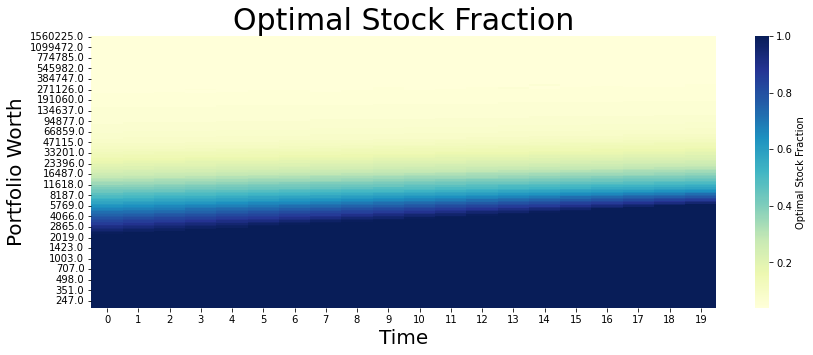

The initial wealth is 10000.0 

The optimal initial fraction in stock is 0.42 

The optimal fraction in stock over time if the wealth stays at its initial value: [0.42 0.42 0.43 0.44 0.44 0.45 0.47 0.48 0.49 0.5  0.5  0.51 0.53 0.54
 0.55 0.57 0.58 0.58 0.6  0.61] 



In [60]:
# Reverse order of each set of states so they display smallest on the bottom
plotgrid_rev = U.round(3).T.copy()
for t in range(T):
    plotgrid_rev[:,t] = list(reversed(plotgrid_rev[:,t]))
    
# Create a dataframe with time on the x-axis and state on the y-axis
df = pd.DataFrame(plotgrid_rev)
df.index = list(reversed(round_(x_array, decimals = 0)))
df.columns = list(round_(range(T), decimals = 3))

# Make, format, and display the plot
fig, ax = subplots(figsize=(14,5))
ax = sns.heatmap(df, fmt="", annot=False, cmap='YlGnBu', cbar_kws={'label': 'Optimal Stock Fraction'}, ax=ax)
plt.title('Optimal Stock Fraction', fontsize =30)
plt.xlabel("Time", fontsize =20) 
plt.ylabel("Portfolio Worth", fontsize =20)
show()

# Print summary information about the calculated optimal controls
i_x0 = argmin(abs(x_array - x_0)) 

print("The initial wealth is", x_array[i_x0].round(2),"\n")
print("The optimal initial fraction in stock is", U[0,i_x0].round(3),"\n")
print("The optimal fraction in stock over time if the wealth stays at its initial value:", U[:,i_x0],"\n")

## $\star$ Programming task: Simulate a random walk applying the optimal control
Simulate n_runs investment histories, starting at with x_0 wealth and applying the optimal control (according to U as populated above) for T timesteps. The plotting code has already been written for you. Add three expressions to the commented out print statements to establish the value (in riskless dollars) of each investment strategy, depending on $\Phi$.

Simulated expected wealth at time 20 : $ 20644.401918971616
Amount of money equivalent in value to investing 10000.0 : 16416
Amount of money equivalent in value to investing 10000.0 : 17838
Amount of money equivalent in value to investing 10000.0 : 10412


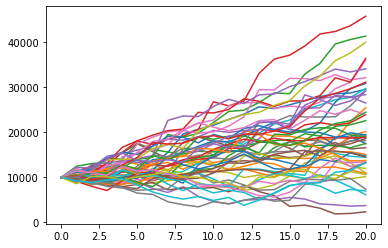

In [61]:
n_runs = 50

x = zeros((T+1,n_runs))
x[0,:] = x_0

# GENERATE n_runs RANDOM WALKS STARTING AT x_0, WHERE x[:,i] GIVES THE WEALTH HISTORY OF AN OPTIMAL INVESTOR OVER TIME

for i in range(n_runs):#run step
    for j in t_array[1:]:#time step
        prev_x = np.maximum(x_min,np.minimum(x[j-dt,i],x_max))
        interp_U = interp1d(x_array, U[j-dt,:],kind = 'linear')
        opt_u = interp_U(prev_x)
        
        #Bellman
        x[j,i] = (1-opt_u)*prev_x*np.exp(r*dt)+opt_u*prev_x*exp((mu-((sigma**2)/2))*dt + sigma*np.sqrt(dt)*np.random.normal())

plot(range(0,T+1,dt),x)
print("Simulated expected wealth at time",T,": $",sum(x[T,:])/n_runs)

# ADD APPROPRIATE EXPRESSIONS IN THE 3 SPOTS BELOW

exp_util = -1.0 #used to store the riskless x values
log_util = -1.0
pow_util = -1.0

exp_smallest_dif = np.inf #tracks the smallest difference
log_smallest_dif = np.inf
pow_smallest_dif = np.inf

mean = sum(x[T,:])/n_runs #mean from the runs done above

exp_gamble_util = sum(1-exp(-alpha_exp*x[T,:]))/n_runs #mean Phi values for each strategy
log_gamble_util = sum(log(alpha_log*x[T,:]))/n_runs
pow_gamble_util = sum(x[T,:]**(1-alpha_pow)/(1-alpha_pow))/n_runs

#old iteration:
#for i in x_array:
for i in range(1,int(x_max)):#run through each x value and find/store each x value that results in a phi similar to the mean of phi's
    exponential_dif = np.abs((1-exp(-alpha_exp*i))-exp_gamble_util) #difference between each phi(x) and phi(gamble)
    log_dif = np.abs((log(alpha_log*i))-log_gamble_util)
    pow_dif = np.abs((i**(1-alpha_pow)/(1-alpha_pow))-pow_gamble_util)
    
    if(exponential_dif < exp_smallest_dif):
        exp_smallest_dif = exponential_dif
        exp_util = i
    if(log_dif < log_smallest_dif):
        log_smallest_dif = log_dif
        log_util = i
    if(pow_dif < pow_smallest_dif):
        pow_smallest_dif = pow_dif
        pow_util = i

print("Amount of money equivalent in value to investing",x_0,":",exp_util) # exponential utility
print("Amount of money equivalent in value to investing",x_0,":",log_util) # log utility
print("Amount of money equivalent in value to investing",x_0,":",pow_util) # power law utility
